# Network Intrusion Detection Using Machine Learning/Deep Learning


In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ========== STANDARD LIBRARIES ==========
import os
import time
import numpy as np
import pandas as pd

# ========== VISUALIZATION ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== SCIKIT-LEARN (Machine Learning) ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# ========== TENSORFLOW / KERAS (Deep Learning) ==========
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Flatten,
    Bidirectional, LSTM, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    CSVLogger, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

Available GPUs: []


In [4]:
!nvidia-smi

Sun Nov  9 13:38:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.32                 Driver Version: 581.32         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   60C    P5             11W /   80W |     452MiB /   4096MiB |     59%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Data Loading and Preprocessing 

file_paths = []
for root, dirs, filenames in os.walk('../Data/'):
    for filename in filenames:
        file_paths.append(os.path.join(root, filename))
        


def load_data(file_paths):
    combined_df = pd.DataFrame()
    for file in file_paths:
        print("Loading:", file)
        data = pd.read_csv(file, low_memory=False)
        
        # Combine with other files
        combined_df = pd.concat([combined_df, data], ignore_index=True, copy=False)

    return combined_df.drop(columns=["Timestamp"]) # remove Timestamp because it's irrelevant to the result

df = load_data(file_paths)
print(df['Label'].value_counts())

target_values = ['DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'Label'] # these targets have too few samples (Label is an error from concatenate data)
df = df[~df['Label'].isin(target_values)]
df = df.groupby('Label', group_keys=False).sample(n=41500, random_state=42)

def clean_data(data):
    encoder = LabelEncoder()
    data['Label'] = encoder.fit_transform(data['Label']) # encode Label (string to number from 0 to 8)
    data = data.apply(pd.to_numeric, errors='coerce') # if error (meet non-numeric value), turn that value into np.nan
    data = data.replace([np.inf, -np.inf], np.nan) # replace inf value (or extreme value) to np.nan
    data = data.dropna()
    return pd.DataFrame(data), encoder
df, encoder = clean_data(df)
df = df.groupby('Label', group_keys=False).sample(n=40000, random_state=42)
# df = pd.DataFrame(df)

print(df['Label'].unique())
print(df['Label'].value_counts())

# Save to output directory


Loading: ../Data/02-14-2018.csv
Loading: ../Data/02-15-2018.csv
Loading: ../Data/02-16-2018.csv
Loading: ../Data/02-21-2018.csv
Loading: ../Data/02-22-2018.csv
Loading: ../Data/02-23-2018.csv
Loading: ../Data/02-28-2018.csv
Loading: ../Data/03-01-2018.csv
Loading: ../Data/03-02-2018.csv
Label
Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Label                            59
Name: count, dtype: int64
[0 1 2 3 4 5 6 7 8]
Label
0    40000
1    40000
2    40000
3    40000
4    40000
5    40000
6    40000
7    40000
8    40000
Name: count, dt

OSError: Cannot save file into a non-existent directory: '..\Data\processed_data'

In [6]:
df.to_csv('../Data/processed_data/cleaned_data_sampled.csv', index=False)

In [7]:
print("Label encoder mapping:")
for i, label in enumerate(encoder.classes_):
    print(f"{i}: {label}")

Label encoder mapping:
0: Benign
1: Bot
2: DDOS attack-HOIC
3: DoS attacks-GoldenEye
4: DoS attacks-Hulk
5: DoS attacks-SlowHTTPTest
6: FTP-BruteForce
7: Infilteration
8: SSH-Bruteforce


In [8]:
def preprocess_and_split(data, test_size=0.2, random_state=42):
    
    X = data.drop('Label', axis=1)
    y = data['Label']         

    X_train, X_test, y_train_ml, y_test_ml = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 3) Fit selector & scaler 
    selector = VarianceThreshold(threshold=0.01)
    X_train_filtered = selector.fit_transform(X_train)
    X_test_filtered  = selector.transform(X_test)

    scaler = RobustScaler(quantile_range=(5, 95))
    X_train_ml = scaler.fit_transform(X_train_filtered)
    X_test_ml  = scaler.transform(X_test_filtered)

    # 4) one hot encoding
    num_classes = int(y.nunique())       
    y_train_cnn = to_categorical(y_train_ml, num_classes=num_classes)
    y_test_cnn  = to_categorical(y_test_ml,  num_classes=num_classes)

    
    X_train_cnn = X_train_ml[..., np.newaxis]
    X_test_cnn  = X_test_ml[...,  np.newaxis]

    return (
        X_train_ml, X_test_ml, y_train_ml, y_test_ml,    
        X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn 
    )


(
    X_train, X_test, y_train_ml, y_test_ml,      
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn  
) = preprocess_and_split(df, test_size=0.2, random_state=42)

print("\nFinal dataset shapes:")
print(f"X_train (ML 2D): {X_train.shape}, y_train_ml: {y_train_ml.shape}")
print(f"X_test  (ML 2D): {X_test.shape},  y_test_ml:  {y_test_ml.shape}")
print(f"X_train_cnn (3D): {X_train_cnn.shape}, y_train_cnn: {y_train_cnn.shape}")
print(f"X_test_cnn  (3D): {X_test_cnn.shape},  y_test_cnn:  {y_test_cnn.shape}")


Final dataset shapes:
X_train (ML 2D): (288000, 67), y_train_ml: (288000,)
X_test  (ML 2D): (72000, 67),  y_test_ml:  (72000,)
X_train_cnn (3D): (288000, 67, 1), y_train_cnn: (288000, 9)
X_test_cnn  (3D): (72000, 67, 1),  y_test_cnn:  (72000, 9)


CNN + BiLSTM + Attention Model
Conv1D: Extracts local patterns from sequential network traffic data (e.g., packet length, frequency, inter-arrival time). → Enables the model to learn short-term behavioral features of network flows.

BatchNormalization: Normalizes outputs between layers to stabilize training and prevent gradient explosion or vanishing issues.

MaxPooling1D: Reduces feature dimensions and highlights dominant local features, improving computational efficiency and filtering out noise.

Dropout: Randomly deactivates a portion of neurons during training → prevents overfitting and improves model generalization.

Bidirectional LSTM: Learns temporal dependencies in both forward and backward directions, helping the model capture contextual attack behaviors (e.g., suspicious packet sequences).

Multi-Head Attention: Focuses on the most critical timesteps in network flows (sudden bursts, unusual activity). → Instead of treating the entire sequence equally, the model automatically emphasizes the most suspicious regions.

GlobalAveragePooling1D: Aggregates temporal features into a compact representation for classification layers.

Dense + Softmax: Combines the extracted features and outputs the probability distribution over attack categories (e.g., Benign, Bot, DoS, DDoS, BruteForce, etc.).

In [9]:
num_classes = y_train_cnn.shape[1]
timesteps = X_train_cnn.shape[1]  # số feature sau selector/scaler
channels  = X_train_cnn.shape[2]  # = 1

inputs = Input(shape=(timesteps, channels), name="inputs")

# --- CNN feature extractor ---
x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

x = Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

# --- BiLSTM (giữ toàn bộ chuỗi cho Attention) ---
x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm")(x)

# --- Multi-Head Self-Attention ---
attn_out = MultiHeadAttention(num_heads=4, key_dim=64, name="mha")(x, x)
x = x + attn_out                       # residual
x = BatchNormalization()(x)

# --- Pooling theo thời gian (tổng hợp có trọng số sau attention) ---
x = GlobalAveragePooling1D(name="gap")(x)

# --- Classifier head ---
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax', name="softmax")(x)

attn_model = Model(inputs, outputs, name="CNN_BiLSTM_Attn")
attn_model.summary()

Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 67, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 67, 128)   │        512 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 67, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 34, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 256)   │     98,560 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 17, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 17, 256)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 17, 256)   │    394,240 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 17, 256)   │    263,168 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 256)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 256)   │      1,024 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 9)         │      1,161 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 793,097 (3.03 MB)

 Trainable params: 791,817 (3.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [10]:
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_cnn))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
try:
    sample_batch = next(iter(train_dataset))[0]  # Get one batch from training set
    output = attn_model(sample_batch, training=False)
    print("Sample model output before training:")
    print(output.numpy())
except Exception as e:
    print("Error generating model output before training:", str(e))

Sample model output before training:
[[0.11376748 0.11329726 0.11123654 ... 0.11036341 0.10921966 0.1109471 ]
 [0.11314109 0.11269966 0.11047044 ... 0.11100867 0.10996224 0.11051149]
 [0.11337403 0.11287662 0.11061464 ... 0.1108276  0.10994697 0.11061852]
 ...
 [0.13626117 0.15489039 0.10203066 ... 0.08254199 0.08888527 0.11569614]
 [0.11586545 0.11507802 0.11130047 ... 0.10976979 0.10759322 0.11088572]
 [0.11301649 0.11272624 0.11062664 ... 0.11095329 0.10996561 0.11064098]]


In [13]:
print(y_train_cnn.shape)
print(y_train_cnn[0])


(288000, 9)
[0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

attn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy' if integer labels
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_attn_model.keras', save_best_only=True, monitor='val_accuracy')
]

history = attn_model.fit(
    train_dataset,
    #validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks
)



Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 263s 230ms/step - accuracy: 0.8169 - loss: 0.4940
Epoch 2/20


c:\Users\Dell\anaconda3\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\Dell\anaconda3\lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 261s 232ms/step - accuracy: 0.8551 - loss: 0.2759
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 268s 238ms/step - accuracy: 0.8575 - loss: 0.2575
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 274s 243ms/step - accuracy: 0.8596 - loss: 0.2535
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 273s 242ms/step - accuracy: 0.8595 - loss: 0.2504
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 268s 238ms/step - accuracy: 0.8606 - loss: 0.2514
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 283s 251ms/step - accuracy: 0.8610 - loss: 0.2478
Epoch 8/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 284s 252ms/step - accuracy: 0.8618 - loss: 0.2465
Epoch 9/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 281s 249ms/step - accuracy: 0.8611 - loss: 0.2464
Epoch 10/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 276s 245ms/step - accuracy: 0.8642 - loss: 0.2432
Epoch 11/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 264s 234ms/step - accuracy: 0.8631 - loss: 0.2441
Epoch 12/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 274s 243ms/step - accuracy: 0.8646 - loss: 0.2

In [ ]:
# Callbacks
lr = 1e-4
optimizer = Adam(learning_rate=lr)
attn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'),
             tf.keras.metrics.Recall(name='Recall')]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    tf.keras.callbacks.TerminateOnNaN()
]


# Training
start_time = time.time()
with tf.device('/GPU:0'):
    print("Training CNN+BiLSTM+Attention...")
    history_attn = attn_model.fit(
        train_dataset,
        epochs=50,
        validation_data=(X_test_cnn, y_test_cnn),
        callbacks=callbacks,
        verbose=1
    )
training_time = time.time()-start_time

print(f"Model trained in {training_time:.2f} seconds")


Evaluating model...
Prediction output shape: (72000, 9)

=== Evaluation Metrics ===
Accuracy : 0.8733 (87.33%)
Precision: 0.8819 (88.19%)
Recall   : 0.8733 (87.33%)
F1-Score : 0.8705 (87.05%)


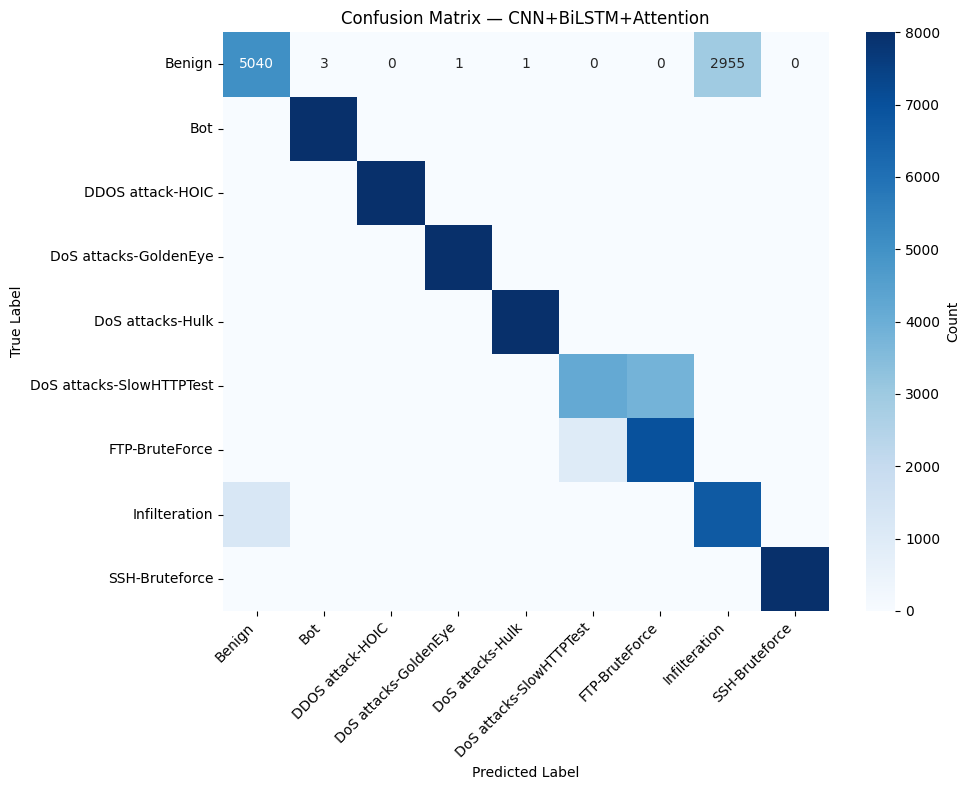

KeyError: 'val_accuracy'

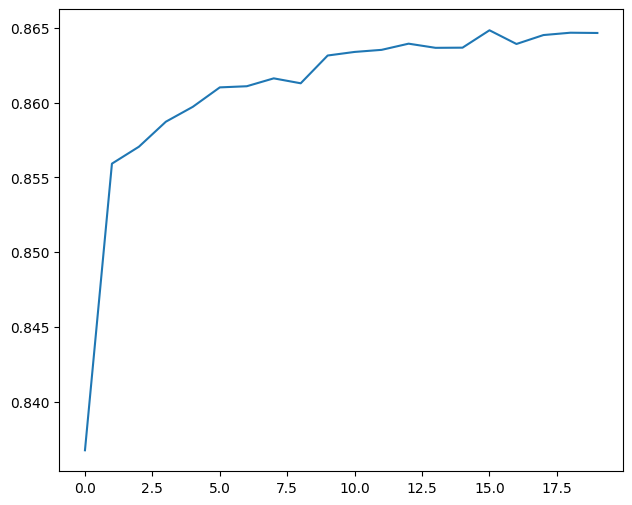

In [ ]:
print("\nEvaluating model...")


y_pred_probs = attn_model.predict(X_test_cnn, verbose=0)
print("Prediction output shape:", y_pred_probs.shape)


y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)


acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"Recall   : {rec:.4f} ({rec*100:.2f}%)")
print(f"F1-Score : {f1:.4f} ({f1*100:.2f}%)")

# === Confusion Matrix ===
labels = list(encoder.classes_)  # encoder đã dùng khi encode y
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix — CNN+BiLSTM+Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



def plot_history(history):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history)


tf.keras.backend.clear_session()


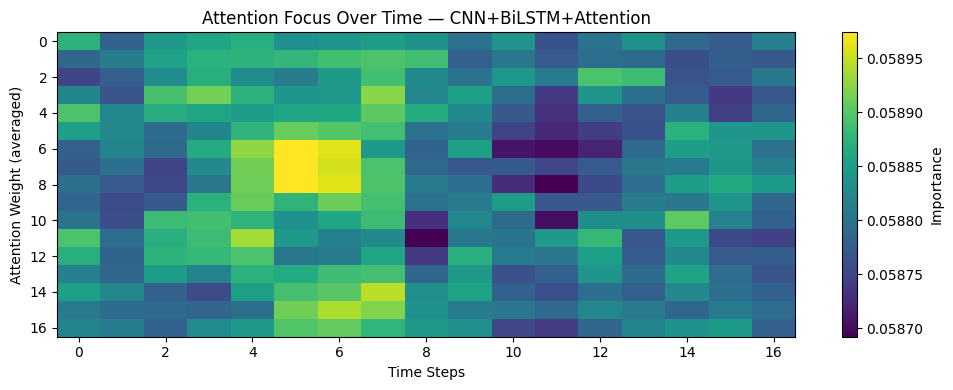

In [ ]:
bilstm_output = attn_model.get_layer('bilstm').output


mha_layer = MultiHeadAttention(num_heads=4, key_dim=64, name="mha_view")
attn_out, attn_scores = mha_layer(bilstm_output, bilstm_output, return_attention_scores=True)


attention_extractor = Model(inputs=attn_model.input, outputs=attn_scores)


n_samples = 8
attn_scores_test = attention_extractor.predict(X_test_cnn[:n_samples], verbose=0)

attn_mean = np.mean(attn_scores_test, axis=1)


plt.figure(figsize=(10, 4))
plt.imshow(attn_mean.mean(axis=0), cmap='viridis', aspect='auto')
plt.title("Attention Focus Over Time — CNN+BiLSTM+Attention")
plt.xlabel("Time Steps")
plt.ylabel("Attention Weight (averaged)")
plt.colorbar(label='Importance')
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))



Detailed Classification Report:
                          precision    recall  f1-score   support

                  Benign       0.80      0.63      0.70      8000
                     Bot       1.00      1.00      1.00      8000
        DDOS attack-HOIC       1.00      1.00      1.00      8000
   DoS attacks-GoldenEye       1.00      1.00      1.00      8000
        DoS attacks-Hulk       1.00      1.00      1.00      8000
DoS attacks-SlowHTTPTest       0.80      0.52      0.63      8000
          FTP-BruteForce       0.64      0.87      0.74      8000
           Infilteration       0.69      0.84      0.76      8000
          SSH-Bruteforce       1.00      1.00      1.00      8000

                accuracy                           0.87     72000
               macro avg       0.88      0.87      0.87     72000
            weighted avg       0.88      0.87      0.87     72000

